In [1]:
# import all library I needed 
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import warnings

In [2]:
# load the csv of the data
df_ad = pd.read_csv('Resources/Advertising.csv').drop(columns = 'Unnamed: 0')
df_ad.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
# test whether there is any nan here
df_ad.isna().any().any()

False

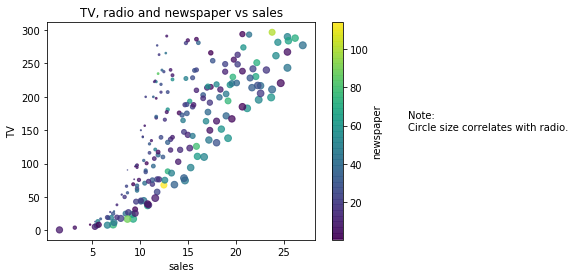

In [4]:
radio_list = df_ad['radio'].tolist()
# making the scatter sharex need to be set as false because of color setting (seems a bug?)
df_ad.plot.scatter(x = 'sales', y = 'TV', s = radio_list, 
                     c = 'newspaper', colormap='viridis', sharex=False, alpha = 0.75)
# text setting
# plt.xlim(1905, 2020)
plt.title("TV, radio and newspaper vs sales")
plt.xlabel("sales")
plt.ylabel("TV")
plt.text(38, 150, 'Note:\nCircle size correlates with radio.')
# figure saving
plt.savefig("Output/TV_radio_newspaper_vs_sales.png", bbox_inches = 'tight', dpi = 300)
plt.show()

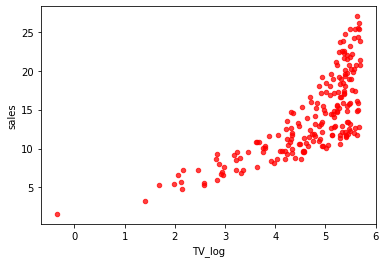

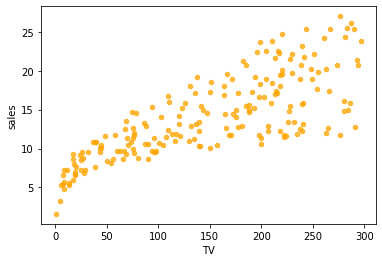

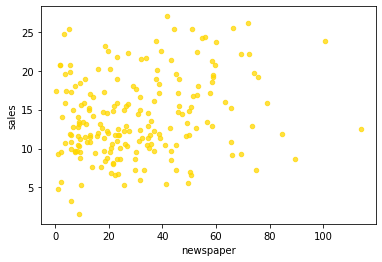

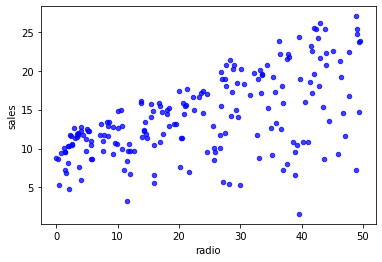

In [5]:
# build 3 different scatter figures separately seems a better way
df_ad['TV_log'] = np.log(df_ad['TV'])
df_ad.plot.scatter(x = 'TV_log', y = 'sales', sharex=False, alpha = 0.75, c = 'red')
df_ad.plot.scatter(x = 'TV', y = 'sales', sharex=False, alpha = 0.75, c = 'orange')
df_ad.plot.scatter(x = 'newspaper', y = 'sales', sharex=False, alpha = 0.75, c = 'gold')
df_ad.plot.scatter(x = 'radio', y = 'sales', sharex=False, alpha = 0.75, c = 'blue')
plt.show()

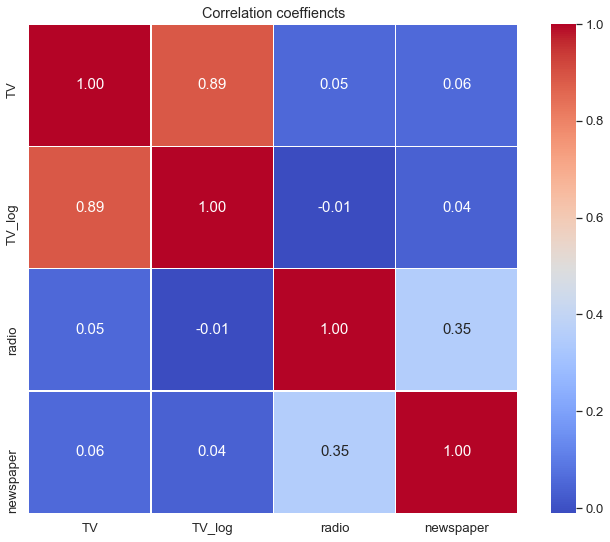

In [6]:
# correlation first as initial
cor_format = df_ad.corr()
# sort correlation around revenue
# here is a bug for plt so there is a cutoff and use ylim to fit it 
# but the order is different so use smallest and invert_xaxis to fix this bug
col_name = cor_format.nsmallest(4, 'sales')['sales'].index
# use np to make the list for the correlation
cor_num = np.corrcoef(df_ad[col_name].dropna(how = 'any').values.T)
# making the figures
plt.figure(figsize = (12,9))
sb.set(font_scale = 1.2)
ax = sb.heatmap(cor_num, cbar = True, annot = True, square = True, fmt = '.2f', 
                annot_kws = {'size': 15}, linewidth = 0.1, cmap = 'coolwarm',
                yticklabels = col_name.values, xticklabels = col_name.values)
plt.title("Correlation coeffiencts")
ax.invert_xaxis()
plt.ylim(0,len(cor_num))
plt.savefig("Output/correlation_heatmap.png", bbox_inches = 'tight', dpi = 300)
plt.show()

In [7]:
# split the data
X=df_ad[['TV_log', 'radio', 'newspaper']]
Y=df_ad['sales']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 15)

In [8]:
# standardized all the data
df_ad_central = df_ad - df_ad.mean(0)
df_ad_std = df_ad_central / df_ad.std(0)
X_std = (X - X.mean())/X.std()
Y_std = Y
x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(X_std, Y_std, test_size=0.2, random_state = 15)

In [9]:
#Grid Search Parameter Tuning
# prepare a range of alpha values to test
warnings.filterwarnings("ignore")
alphas = np.array([20,10,5,1,1e-2,1e-3,1e-4,1e-8,1e-10,1e-15])
# create and fit a ridge regression model, testing each alpha
model_ridge = Ridge()
grid_ridge = GridSearchCV(estimator = model_ridge, param_grid = dict(alpha = alphas),cv = 5)
grid_ridge.fit(x_train_std, y_train_std)
# summarize the results of the grid search
alpha_best_ridge = grid_ridge.best_estimator_.alpha
print("For ridge model, the best alpha is %.2f and the best score is %.4f" 
      %(alpha_best_ridge, grid_ridge.best_score_))

For ridge model, the best alpha is 1.00 and the best score is 0.8956


In [10]:
# fit the model and get the RSS and R^2
ridge1 = Ridge(alpha = alpha_best_ridge)
ridge1.fit(x_train_std, y_train_std)
print ("The R^2 for training set:" + str(ridge1.score(x_train_std, y_train_std)))
print ("The R^2 for test set:" + str(ridge1.score(x_test_std, y_test_std)))
print ("RSS: %.2f" %(np.sum((ridge1.predict(x_test_std) - y_test_std) ** 2)))
print(ridge1.coef_)

The R^2 for training set:0.906847417239725
The R^2 for test set:0.903000842421461
RSS: 114.99
[ 3.85907647  3.04229863 -0.07125944]


In [11]:
# doing same thing for lasso model
warnings.filterwarnings("ignore")
model_lasso = Lasso()
grid_lasso = GridSearchCV(estimator = model_lasso, param_grid = dict(alpha = alphas), cv = 5)
grid_lasso.fit(x_train_std, y_train_std)
alpha_best_lasso = grid_lasso.best_estimator_.alpha
print("For lasso model, the best alpha is %.2f and the best score is %.4f" 
      %(alpha_best_lasso, grid_lasso.best_score_))

For lasso model, the best alpha is 0.01 and the best score is 0.8955


In [12]:
lasso1 = Lasso(alpha = alpha_best_lasso)
lasso1.fit(x_train_std, y_train_std)
print ("The R^2 for training set:" + str(lasso1.score(x_train_std, y_train_std)))
print ("The R^2 for test set:" + str(lasso1.score(x_test_std, y_test_std)))
print ("RSS: %.2f" %(np.sum((lasso1.predict(x_test_std) - y_test_std) ** 2)))
print(lasso1.coef_)

The R^2 for training set:0.9068705606323506
The R^2 for test set:0.9034494461341048
RSS: 114.46
[ 3.87264265  3.04958696 -0.06508653]


In [13]:
# based on this dataset, I want to use ridge model because it fits better based on RSS, 
# but I would like to use lasso model if I want to ignore some unnecessary factors